## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. 导入必要的库
import numpy as np

# 2. 加载数据
file_path = r'C:\Users\wangy\Downloads\homework-practice-06-gradient_boosting\application_train.csv'
data = pd.read_csv(file_path)

# 3. 分离目标变量
Y = data['TARGET']
X = data.drop(columns=['TARGET'])

# 4. 删除不必要的列
# 根据描述删除不相关的或重复的列
columns_to_drop = ['SK_ID_CURR']  # 假设SK_ID_CURR是唯一标识符，不是特征
X = X.drop(columns=columns_to_drop)

# 5. 确定列类型并填充缺失值
# 对数值型和类别型特征分别处理
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

# 数值型特征用中位数填充
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())

# 类别型特征用众数填充
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

# 6. 按70:30的比例分割数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# 输出数据集的基本信息
print("Training set feature shape:", X_train.shape)
print("Test set feature shape:", X_test.shape)
print("Training set target shape:", Y_train.shape)
print("Test set target shape:", Y_test.shape)

Training set feature shape: (215257, 120)
Test set feature shape: (92254, 120)
Training set target shape: (215257,)
Test set target shape: (92254,)


__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import catboost as cb
import time
from sklearn.metrics import average_precision_score
import re

# 1. 加载数据
file_path = r'C:\Users\wangy\Downloads\homework-practice-06-gradient_boosting\application_train.csv'
data = pd.read_csv(file_path)

# 2. 分离目标变量
Y = data['TARGET']
X = data.drop(columns=['TARGET'])

# 3. 删除不必要的列
columns_to_drop = ['SK_ID_CURR']  # 假设SK_ID_CURR是唯一标识符，不是特征
X = X.drop(columns=columns_to_drop)

# 4. 确定列类型并填充缺失值
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

# 数值型特征用中位数填充
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())

# 类别型特征用众数填充
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

# 5. 对类别型特征进行 one-hot 编码
X = pd.get_dummies(X, columns=categorical_features)

# 6. 清理特征名称
def clean_feature_names(df):
    return [re.sub(r'[^\w\s]', '', col).strip().replace(' ', '_') for col in df.columns]

X.columns = clean_feature_names(X)

# 7. 按70:30的比例分割数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# 8. 训练 LightGBM 模型
start_time = time.time()
lgb_train = lgb.Dataset(X_train, Y_train, feature_name=X_train.columns.tolist())
lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train, feature_name=X_test.columns.tolist())

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# 使用 callback 实现早停机制
lgb_model = lgb.train(
    params, 
    lgb_train, 
    num_boost_round=100, 
    valid_sets=[lgb_train, lgb_test], 
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)
lgb_train_time = time.time() - start_time

# 9. 训练 CatBoost 模型
start_time = time.time()
cb_train = cb.Pool(X_train, Y_train)
cb_test = cb.Pool(X_test, Y_test)

cb_model = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=0)
cb_model.fit(cb_train, eval_set=cb_test, early_stopping_rounds=10)
cb_train_time = time.time() - start_time

# 10. 评估模型性能
def evaluate_model(model, X_test, Y_test):
    if isinstance(model, lgb.Booster):
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test, prediction_type='Probability')[:, 1]
    ap_score = average_precision_score(Y_test, y_pred)
    return ap_score

lgb_ap_score = evaluate_model(lgb_model, X_test, Y_test)
cb_ap_score = evaluate_model(cb_model, X_test, Y_test)

# 11. 输出结果
print(f"LightGBM training time: {lgb_train_time:.2f} seconds")
print(f"CatBoost training time: {cb_train_time:.2f} seconds")
print(f"LightGBM average precision-recall (AP) score: {lgb_ap_score:.4f}")
print(f"CatBoost average precision-recall (AP) score: {cb_ap_score:.4f}")

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.777498	valid_1's auc: 0.755286
LightGBM training time: 4.81 seconds
CatBoost training time: 7.02 seconds
LightGBM average precision-recall (AP) score: 0.2347
CatBoost average precision-recall (AP) score: 0.2368



LightGBM использует алгоритм на основе гистограмм для ускорения процесса обучения, а CatBoost использует специальный способ обработки категориальных функций, из-за чего они могут работать по-разному в разных наборах данных.


__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import roc_auc_score
import time

In [2]:
# LightGBM 参数网格
lgb_param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'objective': ['binary'],
    'metric': ['auc']
}

# CatBoost 参数网格
cb_param_grid = {
    'depth': [3, 5, 7],
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss_function': ['Logloss'],
    'eval_metric': ['AUC']
}

In [13]:
# 创建 LightGBM 模型
lgb_model = lgb.LGBMClassifier()

# 使用 GridSearchCV 进行参数搜索
lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=lgb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
lgb_grid_search.fit(X_train, Y_train)

# 输出最优参数
print("LightGBM optimal parameters:", lgb_grid_search.best_params_)
print("LightGBM best AUC:", lgb_grid_search.best_score_)

# 使用最优参数训练模型
best_lgb_model = lgb_grid_search.best_estimator_
best_lgb_model.fit(X_train, Y_train)

# 评估模型
lgb_y_pred = best_lgb_model.predict_proba(X_test)[:, 1]
lgb_auc = roc_auc_score(Y_test, lgb_y_pred)
print("LightGBM test set AUC:", lgb_auc)

LightGBM optimal parameters: {'learning_rate': 0.05, 'max_depth': 7, 'metric': 'auc', 'n_estimators': 200, 'objective': 'binary'}
LightGBM best AUC: 0.7535629861813128
LightGBM test set AUC: 0.758741395926855


In [15]:
# 创建 CatBoost 模型
cb_model = cb.CatBoostClassifier(silent=True)

# 使用 GridSearchCV 进行参数搜索
cb_grid_search = GridSearchCV(estimator=cb_model, param_grid=cb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
cb_grid_search.fit(X_train, Y_train)

# 输出最优参数
print("CatBoost optimal parameters:", cb_grid_search.best_params_)
print("CatBoost best AUC:", cb_grid_search.best_score_)

# 使用最优参数训练模型
best_cb_model = cb_grid_search.best_estimator_
best_cb_model.fit(X_train, Y_train)

# 评估模型
cb_y_pred = best_cb_model.predict_proba(X_test)[:, 1]
cb_auc = roc_auc_score(Y_test, cb_y_pred)
print("CatBoost test set AUC:", cb_auc)

CatBoost optimal parameters: {'depth': 5, 'eval_metric': 'AUC', 'iterations': 200, 'learning_rate': 0.1, 'loss_function': 'Logloss'}
CatBoost best AUC: 0.7539728867498608
CatBoost test set AUC: 0.7581231249260751


In [17]:
# 输出 LightGBM 和 CatBoost 的最优参数
print("LightGBM optimal parameters:")
print(lgb_grid_search.best_params_)

print("CatBoost optimal parameters:")
print(cb_grid_search.best_params_)

LightGBM optimal parameters:
{'learning_rate': 0.05, 'max_depth': 7, 'metric': 'auc', 'n_estimators': 200, 'objective': 'binary'}
CatBoost optimal parameters:
{'depth': 5, 'eval_metric': 'AUC', 'iterations': 200, 'learning_rate': 0.1, 'loss_function': 'Logloss'}


__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import time

# 1. 导入必要的库
import numpy as np

# 2. 加载数据
file_path = r'C:\Users\wangy\Downloads\homework-practice-06-gradient_boosting\application_train.csv'
data = pd.read_csv(file_path)

# 3. 分离目标变量
Y = data['TARGET']
X = data.drop(columns=['TARGET'])

# 4. 删除不必要的列
# 根据描述删除不相关的或重复的列
columns_to_drop = ['SK_ID_CURR']  # 假设SK_ID_CURR是唯一标识符，不是特征
X = X.drop(columns=columns_to_drop)

# 5. 确定列类型并填充缺失值
# 对数值型和类别型特征分别处理
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

# 数值型特征用中位数填充
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())

# 类别型特征用众数填充
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

# 6. 按70:30的比例分割数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# 平滑计数器
def smooth_counts(df, target, cat_features, alpha=1):
    for feature in cat_features:
        counts = df.groupby(feature)[target].agg(['mean', 'count'])
        smoothed = (counts['mean'] * counts['count'] + alpha * df[target].mean()) / (counts['count'] + alpha)
        df[f'{feature}_smooth'] = df[feature].map(smoothed)
        df.drop(columns=[feature], inplace=True)
    return df

# 为训练集和测试集添加目标列
X_train['TARGET'] = Y_train
X_test['TARGET'] = Y_test

X_train_smooth = X_train.copy()
X_test_smooth = X_test.copy()

X_train_smooth = smooth_counts(X_train_smooth, 'TARGET', categorical_features)
X_test_smooth = smooth_counts(X_test_smooth, 'TARGET', categorical_features)

# 移除目标列
X_train_smooth.drop(columns=['TARGET'], inplace=True)
X_test_smooth.drop(columns=['TARGET'], inplace=True)

# OHE编码
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = ohe_encoder.fit_transform(X_train[categorical_features])
X_test_ohe = ohe_encoder.transform(X_test[categorical_features])

# 合并OHE编码后的特征和数值特征
X_train_ohe = pd.concat([X_train[numeric_features].reset_index(drop=True), pd.DataFrame(X_train_ohe)], axis=1)
X_test_ohe = pd.concat([X_test[numeric_features].reset_index(drop=True), pd.DataFrame(X_test_ohe)], axis=1)

# 确保所有列名都是字符串类型
X_train_ohe.columns = X_train_ohe.columns.astype(str)
X_test_ohe.columns = X_test_ohe.columns.astype(str)

# 模型训练与评估

# 7.1 使用OHE编码的数据
# 定义模型
model_ohe = LogisticRegression(max_iter=1000)

# 训练模型
start_time = time.time()
model_ohe.fit(X_train_ohe, Y_train)
end_time = time.time()
time_ohe = end_time - start_time
print(f'Time taken for OHE encoding: {time_ohe} seconds')

# 预测
y_pred_ohe = model_ohe.predict_proba(X_test_ohe)[:, 1]

# 评估
ap_ohe = average_precision_score(Y_test, y_pred_ohe)
print(f'Average Precision (OHE): {ap_ohe}')

# 7.2 使用平滑计数器的数据
# 定义模型
model_smooth = LogisticRegression(max_iter=1000)

# 训练模型
start_time = time.time()
model_smooth.fit(X_train_smooth, Y_train)
end_time = time.time()
time_smooth = end_time - start_time
print(f'Time taken for Smooth Counts: {time_smooth} seconds')

# 预测
y_pred_smooth = model_smooth.predict_proba(X_test_smooth)[:, 1]

# 评估
ap_smooth = average_precision_score(Y_test, y_pred_smooth)
print(f'Average Precision (Smooth Counts): {ap_smooth}')

# 打印结果
print(f'Time taken for OHE encoding: {time_ohe} seconds')
print(f'Average Precision (OHE): {ap_ohe}')

print(f'Time taken for Smooth Counts: {time_smooth} seconds')
print(f'Average Precision (Smooth Counts): {ap_smooth}')

C:\Users\wangy\AppData\Local\Temp\ipykernel_1756\693731699.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['TARGET'] = Y_train
C:\Users\wangy\AppData\Local\Temp\ipykernel_1756\693731699.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['TARGET'] = Y_test
D:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    http

Time taken for OHE encoding: 44.534560441970825 seconds
Average Precision (OHE): 0.1244202832096647
Time taken for Smooth Counts: 32.05719876289368 seconds
Average Precision (Smooth Counts): 0.12376149554892395
Time taken for OHE encoding: 44.534560441970825 seconds
Average Precision (OHE): 0.1244202832096647
Time taken for Smooth Counts: 32.05719876289368 seconds
Average Precision (Smooth Counts): 0.12376149554892395


D:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [18]:
# 8. 从训练集中划分验证集
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

# 8.1 为验证集生成平滑计数器特征
X_val_smooth = X_val.copy()
X_val_smooth = smooth_counts(X_val_smooth, 'TARGET', categorical_features)
X_val_smooth.drop(columns=['TARGET'], inplace=True)

# 8.2 为验证集生成OHE编码特征
X_val_ohe = ohe_encoder.transform(X_val[categorical_features])
X_val_ohe = pd.concat([X_val[numeric_features].reset_index(drop=True), pd.DataFrame(X_val_ohe)], axis=1)
X_val_ohe.columns = X_val_ohe.columns.astype(str)

# 9. 生成验证集上的预测
y_pred_val_ohe = model_ohe.predict_proba(X_val_ohe)[:, 1]
y_pred_val_smooth = model_smooth.predict_proba(X_val_smooth)[:, 1]

# 10. 训练元模型
meta_features = pd.DataFrame({
    'ohe': y_pred_val_ohe,
    'smooth': y_pred_val_smooth
})

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_features, Y_val)

# 11. 生成测试集上的预测
test_meta_features = pd.DataFrame({
    'ohe': y_pred_ohe,
    'smooth': y_pred_smooth
})

y_pred_blend = meta_model.predict_proba(test_meta_features)[:, 1]

# 12. 评估融合模型
ap_blend = average_precision_score(Y_test, y_pred_blend)
print(f'Average Precision (Blending): {ap_blend}')

# 13. 评估单个模型
ap_ohe_single = average_precision_score(Y_test, y_pred_ohe)
ap_smooth_single = average_precision_score(Y_test, y_pred_smooth)

print(f'Average Precision (OHE): {ap_ohe_single}')
print(f'Average Precision (Smooth Counts): {ap_smooth_single}')

Average Precision (Blending): 0.12410106038057778
Average Precision (OHE): 0.1244202832096647
Average Precision (Smooth Counts): 0.12376149554892395


__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[221]	training's auc: 0.813765	valid_1's auc: 0.750699


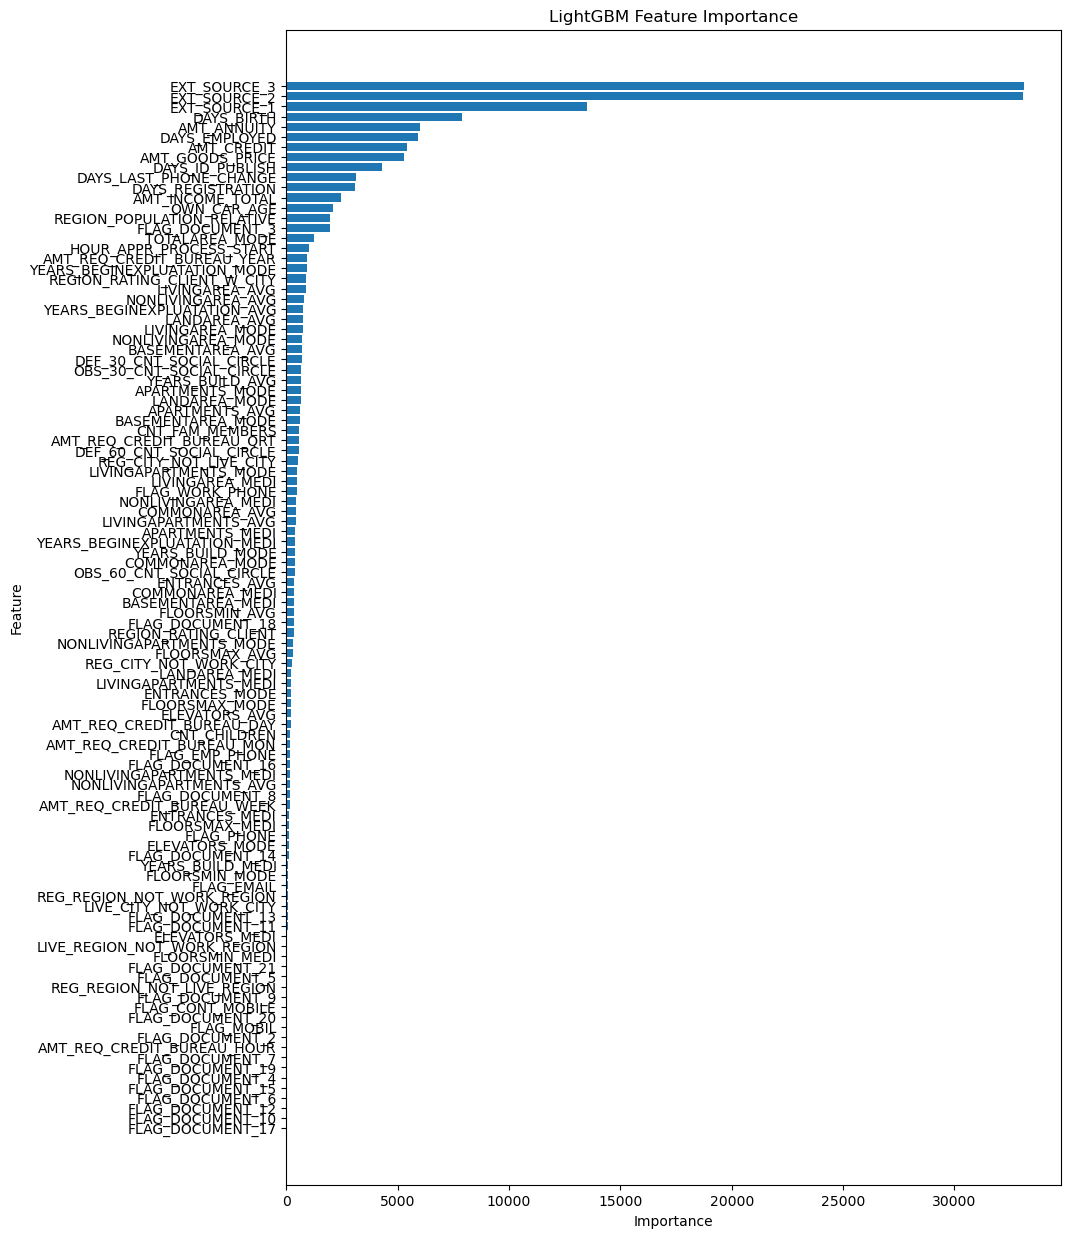

           Feature Id  Importances
0        EXT_SOURCE_3    17.483942
1        EXT_SOURCE_2    15.243610
2        EXT_SOURCE_1    10.012631
3     AMT_GOODS_PRICE     5.700669
4          DAYS_BIRTH     5.111351
..                ...          ...
99    FLAG_DOCUMENT_5     0.000000
100   FLAG_DOCUMENT_9     0.000000
101  FLAG_DOCUMENT_15     0.000000
102  FLAG_DOCUMENT_17     0.000000
103  FLAG_DOCUMENT_19     0.000000

[104 rows x 2 columns]
     feature  importance
0        NaN         NaN
1        NaN         NaN
2        NaN         NaN
3        NaN         NaN
4        NaN         NaN
..       ...         ...
99       NaN         NaN
100      NaN         NaN
101      NaN         NaN
102      NaN         NaN
103      NaN         NaN

[104 rows x 2 columns]
LightGBM important features: ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'AMT_INCO

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# 1. 加载数据
file_path = r'C:\Users\wangy\Downloads\homework-practice-06-gradient_boosting\application_train.csv'
data = pd.read_csv(file_path)

# 2. 分离目标变量
Y = data['TARGET']
X = data.drop(columns=['TARGET'])

# 3. 删除不必要的列
columns_to_drop = ['SK_ID_CURR']  # 假设SK_ID_CURR是唯一标识符，不是特征
X = X.drop(columns=columns_to_drop)

# 4. 确定列类型并填充缺失值
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

# 数值型特征用中位数填充
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())

# 类别型特征用众数填充
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

# 5. 按70:30的比例分割数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# 6. 从训练集中划分验证集
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

# 7. 训练LightGBM模型
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(X_train[numeric_features], Y_train)
lgb_val = lgb.Dataset(X_val[numeric_features], Y_val, reference=lgb_train)

# 使用回调函数实现早停
lgb_model = lgb.train(
    lgb_params, 
    lgb_train, 
    num_boost_round=1000, 
    valid_sets=[lgb_train, lgb_val], 
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 8. 训练CatBoost模型
cb_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': 0,
    'logging_level': 'Silent',
    'early_stopping_rounds': 50  # 添加早停参数
}

cb_train_pool = cb.Pool(X_train[numeric_features], Y_train)
cb_val_pool = cb.Pool(X_val[numeric_features], Y_val)

# 修正cb.train的调用方式
cb_model = cb.CatBoostClassifier(**cb_params)
cb_model.fit(cb_train_pool, eval_set=cb_val_pool)

# 9. 可视化LightGBM特征重要性
lgb_importance = lgb_model.feature_importance(importance_type='gain')
lgb_feature_names = lgb_model.feature_name()

lgb_importance_df = pd.DataFrame({
    'feature': lgb_feature_names,
    'importance': lgb_importance
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 15))
plt.barh(lgb_importance_df['feature'], lgb_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# 10. 可视化CatBoost特征重要性
cb_importance = cb_model.get_feature_importance(prettified=True)
print(cb_importance)  # 打印特征重要性，查看其结构

cb_importance_df = pd.DataFrame(cb_importance, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
print(cb_importance_df)  # 打印特征重要性DataFrame

# 11. 删除不重要的特征
# 根据特征重要性的条形图确定阈值
lgb_threshold = 10  # 你可以根据实际情况调整这个阈值
cb_threshold = 10  # 你可以根据实际情况调整这个阈值

lgb_important_features = lgb_importance_df[lgb_importance_df['importance'] > lgb_threshold]['feature'].tolist()
cb_important_features = cb_importance_df[cb_importance_df['importance'] > cb_threshold]['feature'].tolist()

print(f"LightGBM important features: {lgb_important_features}")
print(f"CatBoost important features: {cb_important_features}")

# 12. 重新训练模型
if len(cb_important_features) > 0:
    # 重新训练LightGBM模型
    lgb_train_important = lgb.Dataset(X_train[lgb_important_features], Y_train)
    lgb_val_important = lgb.Dataset(X_val[lgb_important_features], Y_val, reference=lgb_train_important)

    lgb_model_important = lgb.train(
        lgb_params, 
        lgb_train_important, 
        num_boost_round=1000, 
        valid_sets=[lgb_train_important, lgb_val_important], 
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    # 重新训练CatBoost模型
    cb_train_pool_important = cb.Pool(X_train[cb_important_features], Y_train)
    cb_val_pool_important = cb.Pool(X_val[cb_important_features], Y_val)

    # 修正cb.train的调用方式
    cb_model_important = cb.CatBoostClassifier(**cb_params)
    cb_model_important.fit(cb_train_pool_important, eval_set=cb_val_pool_important)

    # 13. 评估性能变化
    # 评估LightGBM模型
    y_pred_lgb = lgb_model.predict(X_test[numeric_features])
    y_pred_lgb_important = lgb_model_important.predict(X_test[lgb_important_features])

    auc_lgb = roc_auc_score(Y_test, y_pred_lgb)
    auc_lgb_important = roc_auc_score(Y_test, y_pred_lgb_important)

    print(f'ROC AUC (LightGBM with all features): {auc_lgb}')
    print(f'ROC AUC (LightGBM with important features): {auc_lgb_important}')

    # 评估CatBoost模型
    y_pred_cb = cb_model.predict(cb_train_pool)  # 使用训练集的Pool对象进行预测
    y_pred_cb_important = cb_model_important.predict(cb_train_pool_important)  # 使用训练集的Pool对象进行预测

    auc_cb = roc_auc_score(Y_test, y_pred_cb)
    auc_cb_important = roc_auc_score(Y_test, y_pred_cb_important)

    print(f'ROC AUC (CatBoost with all features): {auc_cb}')
    print(f'ROC AUC (CatBoost with important features): {auc_cb_important}')
else:
    print("No important features found for CatBoost. Please adjust the threshold.")